# Pneumonia Classification and Detection


## Small explanation




### Imports

In [187]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
from skimage import measure
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder  
import pydicom as dicom

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Data Load

Data is composed by the X-ray image, a label including the id and the position of the anomalies (if there is one) and finally a class {Pneumonia, Normal, Not pneumonia and Not normal}.

Since the dataset is too much to store in memory, it will need to be loaded on batched during the training process. 
Hence a loader is needed. 

In [188]:
DATA_PATH="./rsna-pneumonia-detection-challenge"

labels_frame = pd.read_csv(DATA_PATH + '/stage_2_train_labels.csv')

detailed_class_info = pd.read_csv(DATA_PATH + '/stage_2_detailed_class_info.csv')

total_images_size = len(detailed_class_info)

train_images_size = int(.8*total_images_size)

train_classes = detailed_class_info.iloc[:train_images_size,:]

train_data = labels_frame.iloc[:train_images_size,:]
train_data['class'] = train_classes['class'].values  

print(train_data.iloc[4,:])
print(train_data.iloc[5,:])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
class                                Lung Opacity
Name: 4, dtype: object
patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             562
y                                             152
width                                         256
height                                        453
Target                                          1
class                                Lung Opacity
Name: 5, dtype: object


In [189]:
def show_square(image,msk,classes):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
        # threshold true mask
    comp = msk[:,:] > 0.5
        # apply connected components
    comp = measure.label(comp)
        # apply bounding boxes
    for region in measure.regionprops(comp):
    
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            ax.add_patch(plt.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
    
    plt.show()

In [190]:
class PneumoniaDataset(data.Dataset):

    def __init__(self, data, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = data
        self.idx = data["patientId"].drop_duplicates()
        self.root_dir = root_dir

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,
                                self.idx.iloc[idx] + ".dcm")
        image = dicom.read_file(img_name).pixel_array
        msk = np.zeros(image.shape)
        landmarks = self.landmarks_frame.loc[(self.landmarks_frame['patientId'] == self.idx.iloc[idx])].iloc[:,1:].as_matrix()
        landmarks = landmarks.reshape(-1, 6)
        for location in landmarks:
                if pd.notna(location[0]):
                    x, y, w, h = location[0:4].astype(int)
                    msk[y:y+h, x:x+w] = 1
        sample = {'image': image,'msk':msk, 'classes': landmarks}


        return sample
    def shuffle_data(self):
        self.idx = self.idx.sample(frac=1).reset_index(drop=True)


### Exploring Data 

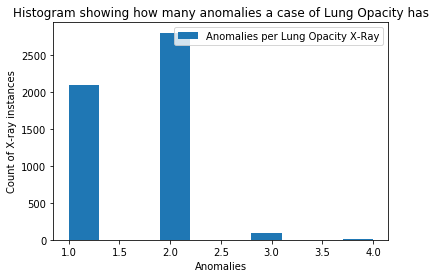

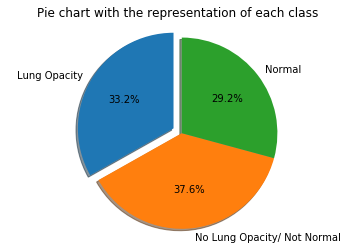

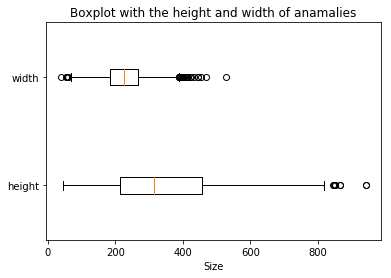

In [191]:
x = train_data.loc[train_data['class'] == 'Lung Opacity'][['patientId','class']].groupby(['patientId','class']).size()


plt.hist(x,label='Anomalies per Lung Opacity X-Ray')
plt.legend()
plt.title('Histogram showing how many anomalies a case of Lung Opacity has')
plt.ylabel('Count of X-ray instances')
plt.xlabel('Anomalies')

plt.show()

x = train_data[['patientId','class']].groupby('class').size()

plt.pie(x,labels= ["Lung Opacity","No Lung Opacity/ Not Normal","Normal"],autopct='%1.1f%%',explode=( 0.1, 0, 0),shadow=True, startangle=90 )
plt.title('Pie chart with the representation of each class')
plt.axis('equal')
plt.show()



plt.boxplot([train_data.loc[train_data['class'] == 'Lung Opacity'].height,train_data.loc[train_data['class'] == 'Lung Opacity'].width],vert=False,labels=["height","width"])
plt.title('Boxplot with the height and width of anamalies')
plt.xlabel('Size')
plt.show()


00704310-78a8-4b38-8475-49f4573b2dbb
Sample #0 (1024, 1024) [[264.0 152.0 213.0 379.0 1 'Lung Opacity']
 [562.0 152.0 256.0 453.0 1 'Lung Opacity']]


<Figure size 432x288 with 0 Axes>

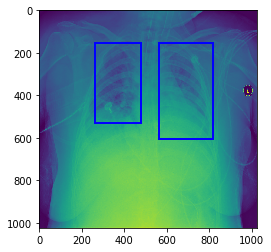

Sample #1 (1024, 1024) [[nan nan nan nan 0 'No Lung Opacity / Not Normal']]


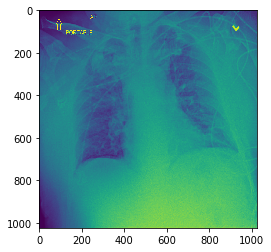

Sample #2 (1024, 1024) [[nan nan nan nan 0 'No Lung Opacity / Not Normal']]


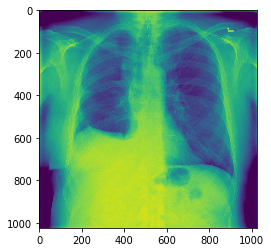

Sample #3 (1024, 1024) [[323.0 577.0 160.0 104.0 1 'Lung Opacity']
 [695.0 575.0 162.0 137.0 1 'Lung Opacity']]


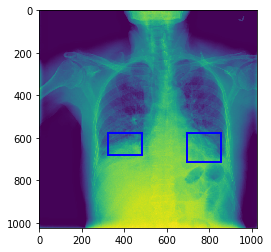

In [192]:
img_name = labels_frame.iloc[8, 0]
print(img_name)
labels = labels_frame.iloc[8, 1:5].as_matrix()
labels = labels.astype('float').reshape(-1, 2).T

face_dataset = PneumoniaDataset(data=train_data,
                                    root_dir='./rsna-pneumonia-detection-challenge/stage_2_train_images')

fig = plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset[i+4]
    print('Sample #{}'.format(i), sample['image'].shape, sample['classes'])
    show_square(**sample)
    if i == 3:
        break


### Training, Validation and Test Set division

### Data preprocessing

### Model

### Training

### Performance Results